In [1]:
import pandas as pd
import numpy as np

import sys, os

import seaborn as sns
import matplotlib.pyplot as plt

from causalinference import CausalModel

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from scipy.stats import wasserstein_distance
from scipy import stats

In /home/adam/.conda/envs/python37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adam/.conda/envs/python37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adam/.conda/envs/python37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/adam/.conda/envs/python37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/adam/.conda/env

In [14]:
os.chdir('/home/adam/files/data/04012020/')
df = pd.read_csv('data_guerin_rct.csv')

In [15]:
df.drop(columns=['pf_ratio_4h_outcome'], inplace=True)
df.dropna(subset=['pf_ratio_12h_outcome'], inplace=True)

In [16]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9740 entries, 1 to 12079
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   treated                    9740 non-null   bool   
 1   age                        9740 non-null   float64
 2   gender                     9740 non-null   object 
 3   bmi                        9740 non-null   float64
 4   nice_diabetes              7490 non-null   object 
 5   nice_chr_renal_insuf       7490 non-null   object 
 6   nice_cirrhosis             7490 non-null   object 
 7   nice_hem_malign            7490 non-null   object 
 8   nice_copd                  7490 non-null   object 
 9   nice_imm_insuf             7490 non-null   object 
 10  sofa_score                 7472 non-null   float64
 11  lactate                    8317 non-null   float64
 12  tidal_volume               9163 non-null   float64
 13  respiratory_rate_measured  8362 non-null   floa

In [24]:
COLS = ['lactate',
        'tidal_volume',
        'respiratory_rate_measured',
        'peep',
        'fio2']
        #'lung_compliance_static'

# tidal volume is highly correlated with lung_compliance
# and tidal volume is more imbalanced and have more observations

COLS_bool = df.filter(regex='med').columns.to_list()

In [20]:
#df_one_hot_encoded = pd.get_dummies(df[COLS_bool])
#df_one_hot_encoded.drop(columns=df_one_hot_encoded.
#                        filter(regex='False').
#                        filter(regex="nice").
#                        columns.
#                        to_list(),
#                        inplace=True)
#
#df_one_hot_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9740 entries, 1 to 12079
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   med_morbid_obesity    9740 non-null   bool 
 1   med_muscle_relaxants  9740 non-null   bool 
 2   med_vasopressors      9740 non-null   bool 
 3   med_glucocorticoids   9740 non-null   bool 
dtypes: bool(4)
memory usage: 434.1 KB


In [25]:
df[COLS].corr().round(2)

,lactate,tidal_volume,respiratory_rate_measured,peep,fio2
lactate,1.00,0.06,0.07,0.08,0.11
tidal_volume,0.06,1.00,-0.06,-0.06,-0.12
respiratory_rate_measured,0.07,-0.06,1.00,-0.10,-0.00
peep,0.08,-0.06,-0.10,1.00,0.20
fio2,0.11,-0.12,-0.00,0.20,1.00


In [37]:
treated = df.iloc[:,0].values.astype('int')
t = df.loc[:, 'treated'].values

X_num = df[COLS].values
X_bool = df[COLS_bool].values

y = df.loc[:, 'pf_ratio_12h_outcome'].values

In [38]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_num)
X_num = imp.transform(X_num)

# Standardize the predictors
scaler = StandardScaler().fit(X_num)
X_num = scaler.transform(X_num)

In [39]:
print(X_num.shape)
print(X_bool.shape)

X = np.hstack((X_num, X_bool))
print(X.shape)

(9740, 5)
(9740, 4)
(9740, 9)


## 3. Causal modelling

In [40]:
# Instantiate CausalModel

causal = CausalModel(y, t, X)
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=8572)        Treated (N_t=1168)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y      141.601       57.078      143.283       60.621        1.683

                      Controls (N_c=8572)        Treated (N_t=1168)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.011        1.026        0.077        0.783        0.096
             X1        0.028        1.007       -0.207        0.923       -0.243
             X2        0.021        1.002       -0.154        0.971       -0.177
             X3       -0.041        0.985        0.298        1.057        0.332
             X4       -0.108        0.925        0.792        1.160        0.857
      

In [33]:
COLS = COLS_num + COLS_bool
X_names = df[COLS].drop(columns=['treated', 'pf_ratio_12h_outcome']).columns.to_list()
ndiff = causal.summary_stats['ndiff']
new_dict = {k: round(v, 2) for k, v in zip(X_names, ndiff)}
print(new_dict)


KeyError: "['treated' 'pf_ratio_12h_outcome'] not found in axis"

In [ ]:
df_summary = pd.DataFrame({'ndiff': ndiff}, index=X_names)
df_summary['ndiff'] = df_summary['ndiff'].map(lambda x: round(x, 2))

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

SEED = 1234
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=SEED,
                         class_weight='balanced',
                         penalty='none').fit(X, t)

pscore = clf.predict_proba(X)[:, 1]

/home/adam/.conda/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/adam/.conda/envs/python37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

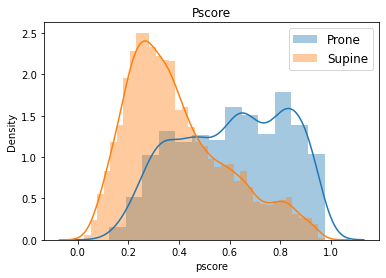

In [43]:
sns.distplot(pscore[t],
             hist = True,
             kde = True,
             label='Prone')

sns.distplot(pscore[~t],
             hist = True,
             kde = True,
             label='Supine')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Pscore')
plt.xlabel('pscore')
plt.ylabel('Density')

In [ ]:
causal.raw_data._dict['pscore'] = pscore

In [44]:
clf.coef_

array([[ 0.07728659, -0.14492528, -0.24845274,  0.10354343,  0.75885547,
        -0.57872167,  0.81155888,  0.06616544, -0.89560926]])

In [45]:
# We assign the new p-score
causal.raw_data._dict['pscore'] = pscore

We trim samples to ensure positivity

In [46]:
causal.trim_s()
print(causal.cutoff)
print(causal.summary_stats)

0.1092857962343523

Summary Statistics

                      Controls (N_c=8220)        Treated (N_t=1059)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y      140.670       55.187      143.687       60.098        3.018

                      Controls (N_c=8220)        Treated (N_t=1059)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       -0.015        1.012        0.069        0.744        0.094
             X1        0.028        1.005       -0.178        0.930       -0.213
             X2        0.015        0.994       -0.135        0.970       -0.152
             X3       -0.036        0.976        0.257        1.053        0.289
             X4       -0.105        0.853        0.616        1.070 

In [47]:
causal.stratify_s()
print(causal.strata)



Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.109     0.205      1143        18     0.164     0.177    28.901
         2     0.205     0.259      1123        37     0.232     0.236     7.871
         3     0.259     0.285       556        24     0.272     0.271    22.603
         4     0.285     0.312       537        43     0.298     0.299     2.399
         5     0.312     0.370      1069        90     0.341     0.342     4.815
         6     0.370     0.442      1065        95     0.404     0.408    16.415
         7     0.442     0.549      1004       156     0.492     0.494    17.442
         8     0.549     0.610       491        89     0.579     0.580    11.508
         9     0.610     0.679       440       140     0.644     0.644    18.554
   

In [48]:
for stratum in causal.strata:
    print(max(stratum.summary_stats['ndiff']))

0.2678602679078958
0.17934742740370288
0.17481436177165482
0.3213915037728535
0.16744690305970308
0.12729814295625658
0.08793458928511266
0.13138463220540306
0.11080982379607174
0.23460498582236003
0.29833214185149376


Now we see that the imbalance decreased a little, but there is
still lot to do.

In [49]:
#causal.reset()

#### Model


In [50]:
causal.est_via_ols()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.370      2.525      4.107      0.000      5.421     15.318
           ATC      9.816      2.664      3.684      0.000      4.594     15.038
           ATT     14.664      2.028      7.230      0.000     10.688     18.639



/home/adam/.conda/envs/python37/lib/python3.7/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


In [60]:
for stratum in causal.strata:
    stratum.est_via_blocking()
[stratum.estimates['blocking']['ate'] for stratum in causal.strata]

TypeError: 'NoneType' object is not iterable

Taking the sample-weighted average of the above within-bin least squares estimates results in a propensity score
matching estimator that is commonly known as the blocking estimator.

In [52]:
# sample-weighted average of the within-bin least squares estimates

causal.est_via_blocking()
print(causal.estimates)



Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.370      2.525      4.107      0.000      5.421     15.318
           ATC      9.816      2.664      3.684      0.000      4.594     15.038
           ATT     14.664      2.028      7.230      0.000     10.688     18.639

Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     13.965      3.767      3.708      0.000      6.582     21.347
           ATC     14.276      4.110      3.474      0.001      6.221     22.330
           ATT     11.551      2.027      5.699      0.000      7.579     15.524



In [53]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.370      2.525      4.107      0.000      5.421     15.318
           ATC      9.816      2.664      3.684      0.000      4.594     15.038
           ATT     14.664      2.028      7.230      0.000     10.688     18.639

Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     13.965      3.767      3.708      0.000      6.582     21.347
           ATC     14.276      4.110      3.474      0.001      6.221     22.330
           ATT     11.551      2.027      5.699      0.000      7.579     15.524

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int

/home/adam/.conda/envs/python37/lib/python3.7/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [54]:
for stratum in causal.strata:
    stratum.est_via_matching()
[stratum.estimates['matching']['ate'] for stratum in causal.strata]


[65.59000861326443,
 5.321551724137931,
 20.549999999999997,
 1.9913793103448276,
 1.8308886971527176,
 17.72887931034483,
 9.969683908045978,
 13.739942528735632,
 18.64913793103448,
 7.5362068965517235,
 3.6848013816925738]

In [55]:
causal.est_via_weighting()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     10.370      2.525      4.107      0.000      5.421     15.318
           ATC      9.816      2.664      3.684      0.000      4.594     15.038
           ATT     14.664      2.028      7.230      0.000     10.688     18.639

Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     13.965      3.767      3.708      0.000      6.582     21.347
           ATC     14.276      4.110      3.474      0.001      6.221     22.330
           ATT     11.551      2.027      5.699      0.000      7.579     15.524

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int

/home/adam/.conda/envs/python37/lib/python3.7/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


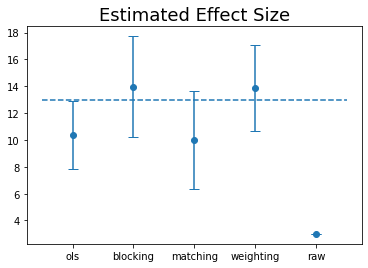

In [57]:
y = []
yerr = []
x_label = []

for method, result in dict(causal.estimates).items():
    y.append(result["ate"])
    yerr.append(result["ate_se"])
    x_label.append(method)

y.append(3)
yerr.append(0)
x_label.append("raw")

x = np.arange(len(y))

plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
plt.xticks(x, x_label)
plt.title("Estimated Effect Size", fontsize=18)
plt.hlines(y=13, xmin=-0.5, xmax = 4.5, linestyles="dashed")
#plt.xlim(-0.5,3.5);
